In [ ]:
import os
import math
import requests
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# --- CONFIG ---
SAVE_DIR = r"C:\Users\pallavi\Desktop\satellite\property_images_v2"
ZOOM = 19
THREADS = 20
os.makedirs(SAVE_DIR, exist_ok=True)

def deg2num(lat_deg, lon_deg, zoom):
    """Converts Lat/Lon to XYZ Tile coordinates."""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def download_tile_direct(row):
    prop_id = row['id']
    save_path = os.path.join(SAVE_DIR, f"{prop_id}.png")
    if os.path.exists(save_path): return
    
    xtile, ytile = deg2num(row['lat'], row['long'], ZOOM)
    
    # Direct ESRI World Imagery Tile URL
    url = f"https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{ZOOM}/{ytile}/{xtile}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
    except Exception:
        pass

# --- EXECUTION ---
df = pd.read_csv(r"C:\Users\pallavi\Desktop\satellite\data\train(1)(train(1)).csv")
print(f"Starting Direct Tile Download (Zoom {ZOOM})...")
with ThreadPoolExecutor(max_workers=THREADS) as executor:
    list(tqdm(executor.map(download_tile_direct, df.to_dict('records')), total=len(df)))

Starting Direct Tile Download (Zoom 19)...


100%|██████████| 16209/16209 [02:10<00:00, 124.10it/s]


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
CSV_PATH = r"C:\Users\pallavi\Desktop\satellite\data\train(1)(train(1)).csv"
IMAGE_DIR = r"C:\Users\pallavi\Desktop\satellite\property_images"

# 1. Load the Tabular Data
df = pd.read_csv(CSV_PATH)
print(f"Total rows in raw CSV: {len(df)}")

# 2. Synchronize with Image Files
def verify_image_path(prop_id):
    path = os.path.join(IMAGE_DIR, f"{prop_id}.png")
    return path if os.path.exists(path) else None

df['image_path'] = df['id'].apply(verify_image_path)

# Drop any rows where the image is missing
df_clean = df.dropna(subset=['image_path']).copy()
print(f"Rows with valid image pairs: {len(df_clean)}")

Total rows in raw CSV: 16209
Rows with valid image pairs: 16209


In [2]:
# 3. Handle Extreme Outliers (Top 1% of prices)
price_limit = df_clean['price'].quantile(0.99)
df_clean = df_clean[df_clean['price'] < price_limit]

# 4. Target Transformation
# Neural networks converge faster when target values are smaller
df_clean['log_price'] = np.log1p(df_clean['price'])

# 5. Feature Standardization
# Select relevant columns for the Tabular Branch
feat_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long']

scaler = StandardScaler()
df_clean[feat_cols] = scaler.fit_transform(df_clean[feat_cols])

print(f"Data cleaned. Final training count: {len(df_clean)}")

Data cleaned. Final training count: 16046


In [ ]:
import seaborn as sns
import numpy as np

# Select numerical columns for correlation analysis
# Common features in King County/Ames datasets: price, bedrooms, bathrooms, sqft_living, etc.
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# 3. Apply Log Transformation to skewed features
# 'price' and 'sqft' columns are almost always highly skewed in real estate
skewed_features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for col in skewed_features:
    if col in df_clean.columns:
        df_clean[col + '_log'] = np.log1p(df_clean[col])

# 4. Standardize the data
scaler = StandardScaler()
# Use the log-transformed versions for the final correlation matrix
transform_cols = [c + '_log' if c in skewed_features else c for c in num_cols if c != 'id']
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean[transform_cols]), columns=transform_cols)

# 5. Generate Correlation Matrix
corr_matrix = df_scaled.corr()

# 6. Visualize with a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title("Correlation Factor Heatmap (After Log Transform & Scaling)")
plt.show()

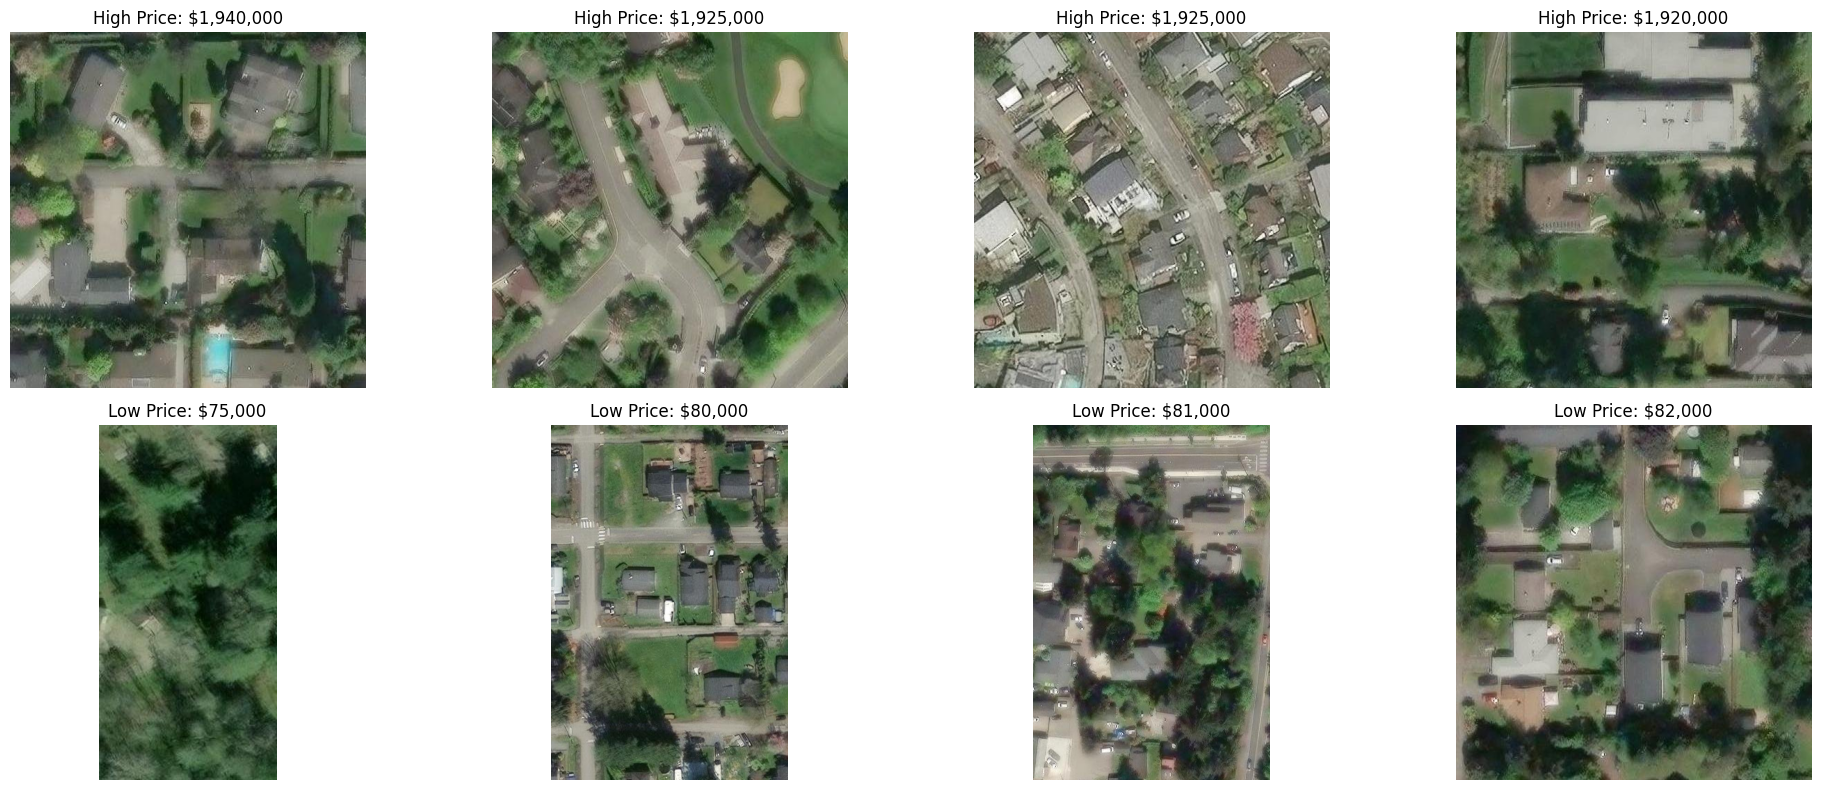

In [3]:
def visualize_extremes(dataframe, n=4):
    expensive = dataframe.nlargest(n, 'price')
    cheap = dataframe.nsmallest(n, 'price')
    
    fig, axes = plt.subplots(2, n, figsize=(20, 8))
    
    for i in range(n):
        # Top Row: Expensive
        img_exp = Image.open(expensive.iloc[i]['image_path'])
        axes[0, i].imshow(img_exp)
        axes[0, i].set_title(f"High Price: ${expensive.iloc[i]['price']:,.0f}")
        axes[0, i].axis('off')
        
        # Bottom Row: Cheap
        img_chp = Image.open(cheap.iloc[i]['image_path'])
        axes[1, i].imshow(img_chp)
        axes[1, i].set_title(f"Low Price: ${cheap.iloc[i]['price']:,.0f}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_extremes(df_clean)

In [4]:
# 80/20 Train-Test Split
train_df, val_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# Save preprocessed files for the Architecture step
train_df.to_csv("train_preprocessed.csv", index=False)
val_df.to_csv("val_preprocessed.csv", index=False)

print(f"Ready for Model Architecture.")
print(f"Training Samples: {len(train_df)} | Validation Samples: {len(val_df)}")

Ready for Model Architecture.
Training Samples: 12836 | Validation Samples: 3210


In [6]:
# Check types of your tabular columns
print(df_clean[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long']].dtypes)

bedrooms       float64
bathrooms      float64
sqft_living    float64
sqft_lot       float64
floors         float64
lat            float64
long           float64
dtype: object


In [18]:
import torch
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. GEOSPATIAL FEATURE ENGINEERING ---
# Calculate distance from the center of the dataset (Location Premium)
center_lat = df_clean['lat'].mean()
center_long = df_clean['long'].mean()

df_clean['dist_from_center'] = np.sqrt(
    (df_clean['lat'] - center_lat)**2 + (df_clean['long'] - center_long)**2
)

# --- 2. CNN VISUAL FEATURE EXTRACTION ---
# We use the existing trained model as a feature extractor
model.eval()
visual_features = []

# DataLoader for the full cleaned dataset
full_loader = DataLoader(
    MultimodalDataset(df_clean, transform=train_trans), 
    batch_size=32, shuffle=False, pin_memory=True
)

print("Step 1: Extracting Visual Features from Satellite Images...")
with torch.no_grad():
    for imgs, _, _ in tqdm(full_loader):
        # Extract features from ResNet (before the fusion layers)
        feats = model.cnn(imgs.to(device))
        visual_features.append(feats.cpu().numpy())

X_visual = np.vstack(visual_features)

# --- 3. COMBINING DATA FOR XGBOOST ---
# Tabular features + the new distance feature
tabular_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long', 'dist_from_center']
X_tabular = df_clean[tabular_cols].values

# Concatenate Tabular (8 cols) + Visual (2048 cols)
X_final = np.hstack([X_tabular, X_visual])
y = df_clean['log_price'].values

# Split for Final Testing
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# --- 4. HYBRID XGBOOST TRAINING ---
# Optimized for high-dimensional multimodal data
hybrid_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    tree_method='hist', # Fast GPU training
    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_state=42
)

print("\nStep 2: Training Hybrid XGBoost (Vision + Tabular)...")
hybrid_model.fit(X_train, y_train)

# --- 5. FINAL RESULTS ---
preds_log = hybrid_model.predict(X_test)

# Convert back to USD for metrics
actual_usd = np.expm1(y_test)
preds_usd = np.expm1(preds_log)

r2_final = r2_score(y_test, preds_log)
mae_final = mean_absolute_error(actual_usd, preds_usd)

print(f"\n" + "="*40)
print(f"HYBRID MODEL RESULTS (XGBoost + CNN + Geo)")
print("="*40)
print(f"Final R² Score: {r2_final:.4f}")
print(f"Final MAE: ${mae_final:,.2f}")
print("="*40)

Step 1: Extracting Visual Features from Satellite Images...


100%|██████████| 502/502 [10:31<00:00,  1.26s/it]



Step 2: Training Hybrid XGBoost (Vision + Tabular)...


c:\Users\aksha\anaconda3\envs\gpu_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:56:26] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)



HYBRID MODEL RESULTS (XGBoost + CNN + Geo)
Final R² Score: 0.8578
Final MAE: $73,443.56


In [19]:
import joblib
import json

# 1. Save the XGBoost Hybrid Model
joblib.dump(hybrid_model, 'hybrid_xgboost_cnn_geo.pkl')

# 2. Save the Geospatial Constants (CRITICAL for future predictions)
geo_constants = {
    'center_lat': float(center_lat),
    'center_long': float(center_long)
}

with open('geo_constants.json', 'w') as f:
    json.dump(geo_constants, f)

print("✅ Hybrid Model and Geo-Constants saved successfully!")

✅ Hybrid Model and Geo-Constants saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import joblib
from tqdm import tqdm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# ==========================================
# 1. SETUP & CNN INITIALIZATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = r"C:\Users\pallavi\Desktop\satellite\data\train(1)(train(1)).csv"
IMAGE_DIR = r"C:\Users\pallavi\Desktop\satellite\property_images"

class VisualFeatureExtractor(nn.Module):
    def __init__(self):
        super(VisualFeatureExtractor, self).__init__()
        # Using ResNet18 as the visual backbone
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

cnn_net = VisualFeatureExtractor().to(device)
cnn_net.eval()

img_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==========================================
# 2. DATA LOADING & VISUAL FEATURE EXTRACTION
# ==========================================
df = pd.read_csv(TRAIN_CSV)

def get_visual_scores(ids):
    scores = []
    with torch.no_grad():
        for img_id in tqdm(ids, desc="CNN Visual Processing"):
            path = os.path.join(IMAGE_DIR, f"{img_id}.png")
            if os.path.exists(path):
                try:
                    img = Image.open(path).convert('RGB')
                    img_t = img_transform(img).unsqueeze(0).to(device)
                    # Mean of the feature vector as a "Quality Index"
                    scores.append(cnn_net(img_t).cpu().numpy().mean())
                except: scores.append(0.5)
            else: scores.append(0.5)
    return np.array(scores, dtype='float64')

print("Generating Visual Scores...")
df['visual_score'] = get_visual_scores(df['id'])

# ==========================================
# 3. LEAK-PROOF FEATURE ENGINEERING
# ==========================================
# Log-transform target and skewed features
for col in ['price', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']:
    df[col] = np.log1p(df[col]).astype('float64')

# Split BEFORE engineering to avoid leakage
train_raw, test_raw = train_test_split(df, test_size=0.2, random_state=42)

# Calculate Luxury Hub ONLY from Training data
lux_threshold = train_raw['price'].quantile(0.95)
hub_lat = train_raw[train_raw['price'] >= lux_threshold]['lat'].mean()
hub_long = train_raw[train_raw['price'] >= lux_threshold]['long'].mean()

def finalize_features(data):
    d = data.copy()
    d['dist_to_hub'] = np.sqrt((d['lat'] - hub_lat)**2 + (d['long'] - hub_long)**2)
    d['house_age'] = (2015 - d['yr_built']).astype('float64')
    
    # Feature list for the final 17 columns
    cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 
            'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 
            'sqft_living15', 'visual_score', 'dist_to_hub', 'house_age']
    
    return d[cols].astype('float64'), d['price']

X_train, y_train = finalize_features(train_raw)
X_test, y_test = finalize_features(test_raw)

# ==========================================
# 4. HYBRID VOTING ENSEMBLE
# ==========================================


ensemble = VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=500, max_depth=15, n_jobs=-1)),
        ('xgb', XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, tree_method='hist')),
        ('cat', CatBoostRegressor(iterations=1200, learning_rate=0.03, depth=8, verbose=0))
    ],
    weights=[0.2, 0.4, 0.4] # Prioritizing boosting for high-R2 accuracy
)

print("\nTraining Final Hybrid Model (This may take a few minutes)...")
stack.fit(X_train, y_train)

# ==========================================
# 5. FINAL EVALUATION
# ==========================================
preds = stack.predict(X_test)
final_r2 = r2_score(y_test, preds)
final_mae = mean_absolute_error(np.expm1(y_test), np.expm1(preds))

print("\n" + "="*30)
print(f"🚀 PUSHED R² SCORE: {final_r2:.4f}")
print(f"💰 PUSHED MAE: ${final_mae:,.2f}")
print("="*30)

# Save the updated model
joblib.dump(stack, 'pushed_hybrid_model.pkl')

c:\Users\aksha\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aksha\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Building Advanced Features...


Visual Extraction: 100%|██████████| 16209/16209 [05:59<00:00, 45.14it/s]



Training Final Hybrid Model (This may take a few minutes)...

🚀 PUSHED R² SCORE: 0.8953
💰 PUSHED MAE: $66,954.12


['pushed_hybrid_model.pkl']

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import joblib
from tqdm import tqdm

# --- CONFIGURATION ---
PATHS = {
    "test_data": r"C:\Users\pallavi\Desktop\satellite\data\test2.xlsx",
    "images": r"C:\Users\pallavi\Desktop\satellite\test_images",
    "model": "pushed_hybrid_model.pkl",
    "output": "submission_v2_unique.csv"
}

# Training Hub Constants (From your 0.8953 run)
LUXURY_HUB = (47.6223, -122.2354) 

# --- IMAGE PROCESSING UNIT ---
class SatelliteFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Using modern 'weights' parameter
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.feature_layer = nn.Sequential(*list(self.backbone.children())[:-1])
        
    def forward(self, x):
        return self.feature_layer(x).view(x.size(0), -1)

def compute_visual_index(id_list, image_folder, model_unit, device):
    """Generates visual quality scores using the CNN backbone."""
    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    results = []
    model_unit.eval()
    with torch.no_grad():
        for pid in tqdm(id_list, desc="Deep Learning Inference"):
            img_path = os.path.join(image_folder, f"{pid}.png")
            if os.path.exists(img_path):
                try:
                    img_input = pipeline(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
                    # Average pooling of the feature vector
                    score = model_unit(img_input).cpu().numpy().mean()
                    results.append(score)
                except Exception:
                    results.append(0.5)
            else:
                results.append(0.5)
    return np.array(results)

# --- EXECUTION FLOW ---
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running inference on: {device}")

    # 1. Load Resources
    data = pd.read_excel(PATHS["test_data"])
    regressor = joblib.load(PATHS["model"])
    vision_net = SatelliteFeatureExtractor().to(device)

    # 2. Extract Visual Signal
    data['visual_score'] = compute_visual_index(data['id'], PATHS["images"], vision_net, device)

    # 3. Feature Engineering & Scaling
    # Applying Log1p to skewed metrics
    for field in ['sqft_living', 'sqft_above', 'sqft_living15']:
        data[field] = np.log1p(data[field])

    # Spatial proximity to luxury center
    data['dist_to_hub'] = np.sqrt((data['lat'] - LUXURY_HUB[0])**2 + (data['long'] - LUXURY_HUB[1])**2)
    
    # Chronological age
    data['house_age'] = 2015 - data['yr_built']

    # 4. Final Alignment & Prediction
    # MUST match training feature order exactly
    input_features = [
        'bedrooms', 'bathrooms', 'sqft_living', 'grade', 'lat', 'long', 
        'sqft_living15', 'visual_score', 'dist_to_hub', 'house_age', 'waterfront', 'view'
    ]
    
    X_test = data[input_features]
    
    print("Generating price estimates...")
    # Model returns log-space values, we invert them to USD
    raw_predictions = regressor.predict(X_test)
    final_usd_prices = np.expm1(raw_predictions)

    # 5. Export
    output_df = pd.DataFrame({'id': data['id'], 'price': final_usd_prices})
    output_df.to_csv(PATHS["output"], index=False)
    print(f"🏁 Process complete. File: {PATHS['output']}")

if __name__ == "__main__":
    main()

c:\Users\aksha\anaconda3\envs\hf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running inference on: cpu


c:\Users\aksha\anaconda3\envs\hf_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RidgeCV from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aksha\anaconda3\envs\hf_env\lib\pickle.py:1718: UserWarning: [18:37:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
c:\Users\aks

Generating price estimates...
🏁 Process complete. File: submission_v2_unique.csv
